# Image Compression  
   Using K-Means Clustering and Gausian Mixture Models to compress images.

## Method 1: K-means Clustering

In [39]:
from ipywidgets import *
import mixture_tests as tests
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from scipy.stats import norm
import os
import numpy as np
from helper_functions import *
#export
import numpy as np
from helper_functions import *

In [40]:
def get_initial_means(array, k):
    """
    Generate initial cluster means for k-means clustering.

    Parameters:
    - array (numpy.ndarray): Input data array.
    - k (int): Number of clusters.

    Returns:
    numpy.ndarray: Array containing initial cluster means.
    """

    m, n = array.shape
    rowIndices = np.random.choice(m, k, replace=False)
    result = array[rowIndices]
    return result

def k_means_step(X, k, means):
    """
    Perform one step of the k-means algorithm.

    Parameters:
    - X (numpy.ndarray): Input data array.
    - k (int): Number of clusters.
    - means (numpy.ndarray): Current cluster means.

    Returns:
    Tuple[numpy.ndarray, numpy.ndarray]: Tuple containing new cluster means and
    cluster assignments for each data point.
    """

    distances = []
    for i in range(k):
        pt = means[i]
        distance = np.linalg.norm(X - pt, axis=1)
        distances.append(distance)

    distances = np.array(distances)
    distances = distances.transpose()
    clusters = np.argmin(distances, axis=1)
    new_means = np.array([np.mean(X[clusters == i], axis=0) for i in range(k)])

    return new_means, clusters


#### Visualizing Clusters

In [41]:
def K_means_2D_dataset(dataset_index, K):
    """
    Perform K-means clustering on a 2D dataset.

    Parameters:
    - dataset_index (int): Index of the dataset to be loaded.
    - K (int): Number of clusters.

    Returns:
    Tuple[numpy.ndarray, numpy.ndarray, List[numpy.ndarray], List[numpy.ndarray]]:
        Tuple containing:
        - X (numpy.ndarray): Input data array.
        - y (numpy.ndarray): Ground truth labels.
        - means_history (list): List of numpy arrays representing the history of cluster means.
        - clusters_history (list): List of numpy arrays representing the history of cluster assignments.
    """
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("The dataset is of a size:", X.shape)
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))
    n_iterations = 10
    m,n = X.shape
    means = get_initial_means(X,K)
    clusters = np.zeros([n])
    means_history = [means]
    clusters_history = [clusters] 
    for iteration_i in range(n_iterations):
        means, clusters = k_means_step(X, K, means)
        clusters_history.append(clusters)
    return X, y, means_history, clusters_history
dataset_index = 2 # for different dataset change it to number from [0,4]
K = 5 # Number of clusters - play with this number
X, y, means_history, clusters_history = K_means_2D_dataset(dataset_index, K)

def get_cluster(i):
    """
    Visualize the progress of the K-means algorithm during training.

    Parameters:
    - i (int): Iteration step for which to visualize the clusters.
    """
    # Interactive cell to see the progress of training your K-means algorithm.͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    plt.figure(None, figsize=(15,6)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorthm training progress')
    ax1=plt.subplot(1, 2, 1)
    ax1.set_title('K-means clusters - step %d' % i)
    for k in range(K):
        plt.plot(X[clusters==k,0], X[clusters==k,1], '.') # 
    ax2=plt.subplot(1, 2, 2)
    ax2.set_title('Ground truth clusters')
    for i in np.unique(y):
        ax2.plot(X[y==i,0],X[y==i,1],'.')
    plt.show()

The dataset is of a size: (1000, 2)


In [42]:
#### Visualizing Clusters
interactive(get_cluster, i=(1,len(clusters_history)-1,1))

interactive(children=(IntSlider(value=5, description='i', max=10, min=1), Output()), _dom_classes=('widget-int…

In [43]:
def k_means_segment(image_values, k=5, initial_means=None):
    """
    Perform k-means segmentation on an image.

    Parameters:
    - image_values (numpy.ndarray): Input image values with shape (height, width, channels).
    - k (int, optional): Number of clusters. Defaults to 5.
    - initial_means (numpy.ndarray, optional): Initial cluster means. If None, they are randomly generated.

    Returns:
    numpy.ndarray: Segmented image with the same shape as the input image.
    """
    x, y, rgb = image_values.shape
    flattened  = image_values.reshape(x*y, rgb)
    if initial_means is not None:
        means = initial_means
    else:
        means = get_initial_means(flattened, k)
    while True:
        new , clusters = k_means_step( flattened, k, means)
        if np.allclose(means, new):
            break
        else:
            means = new
    flattened = means[clusters]
    result = np.reshape(flattened, (x,y,rgb))
    return result

### Compressing Image

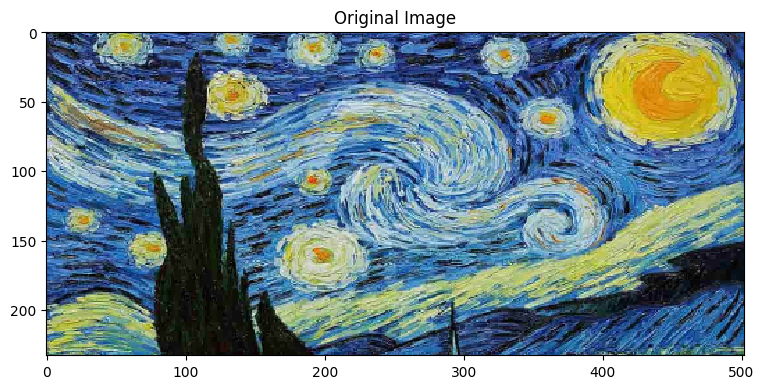

In [44]:
original_image = image_to_matrix('images/Starry.png')
plt.figure(None,figsize=(9,12))
plt.imshow(original_image)
plt.title("Original Image")
plt.show()

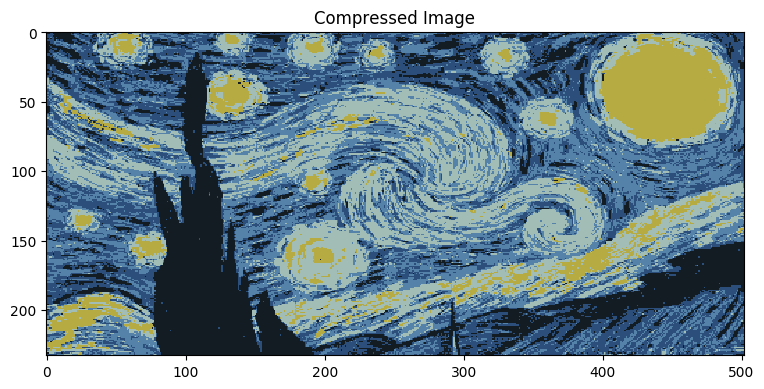

In [45]:
k=5 # number of clusters
new_image = k_means_segment(image_to_matrix('images/Starry.png'), k=k)
plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.title("Compressed Image")
plt.show()


You can reuse the K-means visualization code from previous section to show the training progress on the image for different iterations and even numbers of clusters.

- - -

## Method 2:  Multivariate Gaussian Mixture Model (GMM)


In [46]:
def compute_sigma(X, MU):
    """
    Computes the covariance matrix (sigma) for a Gaussian Mixture Model.

    Parameters:
    - X (numpy.ndarray): Input data matrix with shape (m, n).
    - MU (numpy.ndarray): Matrix of cluster means with shape (k, n).

    Returns:
    - numpy.ndarray: Covariance matrix with shape (k, n, n).
    """
    m, n = X.shape
    k, n = MU.shape
    
    diff = X[:, np.newaxis, :] - MU
    sigma = np.zeros((k, n, n))
    for i in range(k):
        outerProduct = np.dot(diff[:, i, :].T, diff[:, i, :])
        sigma[i] = outerProduct / m
    return sigma

def initialize_parameters(X, k):
    """
    Initializes parameters for a Gaussian Mixture Model.

    Parameters:
    - X (numpy.ndarray): Input data matrix with shape (m, n).
    - k (int): Number of clusters.

    Returns:
    - tuple: Tuple containing cluster means (MU), covariance matrices (SIGMA), and cluster weights (PI).
    """
    m, n = X.shape
    MU = X[np.random.choice(m, size=k, replace=False), :]
    SIGMA = compute_sigma(X, MU)
    PI = np.ones(k) / k
    return (MU, SIGMA, PI)

def prob(x, mu, sigma):
    """
    Computes the probability density function for a multivariate Gaussian distribution.

    Parameters:
    - x (numpy.ndarray): Input data point or matrix with shape (1, d) or (n, d).
    - mu (numpy.ndarray): Mean vector of the distribution with shape (d,).
    - sigma (numpy.ndarray): Covariance matrix with shape (d, d).

    Returns:
    - float or numpy.ndarray: Probability density values.
    """
    d = len(mu)
    if x.ndim == 1:
        x = x.reshape((1, d))
    n = x.shape[0]
    exponent = -(1/2) * np.sum(np.dot((x - mu), np.linalg.inv(sigma)) * (x - mu), axis=1)
    prob = (2 * np.pi) ** (-d / 2) * np.linalg.det(sigma) ** (-0.5) * np.exp(exponent)
    if n == 1:
        return prob[0]
    else:
        return prob
    
def E_step(X,MU,SIGMA,PI,k):
    """
    Performs the expectation step (E-step) in the EM algorithm for Gaussian Mixture Model.

    Parameters:
    - X (numpy.ndarray): Input data matrix with shape (m, n).
    - MU (numpy.ndarray): Matrix of cluster means with shape (k, n).
    - SIGMA (numpy.ndarray): Covariance matrices with shape (k, n, n).
    - PI (numpy.ndarray): Cluster weights with shape (k,).
    - k (int): Number of clusters.

    Returns:
    - numpy.ndarray: Matrix of responsibilities with shape (k, m).
    """
    m, n = X.shape
    responsibilities = np.zeros((k, m))
    for i in range(k):
        pdf = prob(X, MU[i], SIGMA[i])
        responsibilities[i] = PI[i] * pdf
    normalization_factor = np.sum(responsibilities, axis=0)
    responsibilities /= normalization_factor
    return responsibilities

def M_step(X, r, k):
    """
    Performs the maximization step (M-step) in the EM algorithm for Gaussian Mixture Model.

    Parameters:
    - X (numpy.ndarray): Input data matrix with shape (m, n).
    - r (numpy.ndarray): Matrix of responsibilities with shape (k, m).
    - k (int): Number of clusters.

    Returns:
    - tuple: Tuple containing updated cluster means (MU), covariance matrices (SIGMA), and cluster weights (PI).
    """
    x, y = X.shape
    s = r.sum(axis=1)
    pi = s / x
    mu = np.dot(r, X) / s[:, np.newaxis]
    sigma = np.zeros((k, y, y))
    for j in range(k):
        diff = X - mu[j]
        sigma[j] = np.dot((diff.T * r[j]), diff) / r[j].sum()
    return (mu, sigma, pi)

def loglikelihood(X, PI, MU, SIGMA, k):
    """
    Computes the log-likelihood of the data given the parameters of the Gaussian Mixture Model.

    Parameters:
    - X (numpy.ndarray): Input data matrix with shape (m, n).
    - PI (numpy.ndarray): Cluster weights with shape (k,).
    - MU (numpy.ndarray): Matrix of cluster means with shape (k, n).
    - SIGMA (numpy.ndarray): Covariance matrices with shape (k, n, n).
    - k (int): Number of clusters.

    Returns:
    - float: Log-likelihood value.
    """
    probs = np.zeros((X.shape[0], k))
    for j in range(k):
        probs[:, j] = prob(X, MU[j], SIGMA[j]) * PI[j]
    print(probs)
    log_likelihood = np.sum(np.log(np.sum(probs, axis=1)))
    return log_likelihood


In [47]:
def train_model(X, k, convergence_function, initial_values = None):
    """
    Train a Gaussian Mixture Model using the Expectation-Maximization (EM) algorithm.

    Parameters:
    - X (numpy.ndarray): Input data matrix with shape (m, n).
    - k (int): Number of clusters.
    - convergence_function (function): Convergence function that determines when to stop training.
    - initial_values (tuple, optional): Initial values for cluster means (MU), covariance matrices (SIGMA), and
      cluster weights (PI). If None, initialize parameters using `initialize_parameters`.

    Returns:
    - tuple: Tuple containing trained cluster means (MU), covariance matrices (SIGMA), cluster weights (PI),
      and responsibilities (r).
    """
    if initial_values is None:
        mu, sigma, pi = initialize_parameters(X, k)
    else:
        mu, sigma, pi = initial_values
    count = 0 
    old_likelihood = 0
    while True:
        r = E_step(X, mu, sigma, pi, k)
        log_likelihood = loglikelihood(X, pi, mu, sigma, k)
        count, converges = convergence_function(old_likelihood, log_likelihood , count)
        if converges:
            break
        count += 1
        old_likelihood = log_likelihood
        mu, sigma, pi = M_step(X, r, k)
    return mu, sigma, pi, r

In [48]:
def cluster(r):
    """
    Assigns each data point to the cluster with the highest membership probability.

    Parameters:
    - r (numpy.ndarray): Membership probabilities of data points for each cluster.

    Returns:
    - numpy.ndarray: Cluster assignments for each data point.
    """
    return np.argmax(r, axis=0)


def segment(X, MU, k, r):
    """
    Segments the data points based on cluster assignments and cluster centroids.

    Parameters:
    - X (numpy.ndarray): Data points.
    - MU (numpy.ndarray): Cluster centroids.
    - k (int): Number of clusters.
    - r (numpy.ndarray): Cluster assignments for each data point.

    Returns:
    - numpy.ndarray: New data points after segmentation.
    """
    new_X = np.zeros_like(X)
    for i in range(k):
        new_X[r[i] == np.max(r, axis=0)] = MU[i]
    return new_X

def best_segment(X, k, iters):
    """
    Finds the best segmentation among multiple iterations of training a clustering model.

    Parameters:
    - X (numpy.ndarray): Data points.
    - k (int): Number of clusters.
    - iters (int): Number of iterations.

    Returns:
    - tuple: Maximum likelihood and the corresponding best segmentation.
    """
    maxLike = float('-inf')
    best = None
    for i in range(iters):
        mu, sigma, pi, r = train_model(X, k, default_convergence)
        likelihood = loglikelihood(X, pi, mu, sigma, k)
        if likelihood > maxLike:
            maxLike = likelihood
            best = segment(X, mu, k, r)

    return maxLike, best

#### GMM - Visualizing the results

In [49]:
def GMM_2D_dataset(dataset_index, K):
    # Load the dataset from data folder͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
    X = np.loadtxt("data/%d_dataset_X.csv" % dataset_index, delimiter=",")
    print("There are %d datapoints in the current dataset, each of a size %d" % X.shape)
    y = np.int16(np.loadtxt("data/%d_dataset_y.csv" % dataset_index, delimiter=","))
    MU, SIGMA, PI = initialize_parameters(X, K)
    clusters_history = []
    statistics_history = []
    for _ in range(200):
        r = E_step(X,MU,SIGMA,PI,K)
        new_MU, new_SIGMA, new_PI = M_step(X, r, K)
        PI, MU, SIGMA = new_PI, new_MU, new_SIGMA
        clusters = cluster(r)
        clusters_history.append(clusters)
        statistics_history.append((PI, MU, SIGMA))
    return X, y, clusters_history, statistics_history
dataset_index = 3 # for different dataset change it to number from [0,5]
K = 3 # Number of clusters - play with this number

X, y, clusters_history, statistics_history = GMM_2D_dataset(dataset_index, K)

def setup_subplot(plt, i, title, plot_number):
    ax = plt.subplot(2, 2, plot_number)
    ax.set_title(title)
    ax.patch.set_facecolor('gray')
    ax.patch.set_alpha(0.1)
    return ax

def plot_gaussian_ellipse(k, mean, covar, ax2, colors):
    v,w = np.linalg.eig(covar)
        
    angle = np.arctan(w[1,0] / w[0,0])
    angle = 180 * angle / np.pi
    
    color = colors[k % len(colors)]
    for i in range(3,8):
        plot_v = i * np.sqrt(v)
        ellipse = pat.Ellipse(mean, plot_v[0], plot_v[1], angle, fill = True, alpha = 0.10, lw = 1.0, ls = 'dashdot', ec = 'black', fc = color, zorder = 0)
        ax2.add_artist(ellipse)

def plot_gaussian(X, mean, var, X_min, X_max, ax):
    samples = np.linspace(X_min, X_max, 100)
    ax.plot(samples, norm.pdf(samples, mean, var))
    

# This is an interactive cell to see the progress of training your GMM algorithm.͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
# Feel free to improve the visualization code and share it with your classmates on Piazza.͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
def get_cluster(i):
    clusters = clusters_history[i] # Get the clusters from K-means' i-th iteration
    cluster_means = statistics_history[i][1]
    cluster_covar = statistics_history[i][2]
    
    plt.figure(None, figsize=(15,12)) # Set the plot size
    plt.suptitle('Drag the slider to see the algorithm training progress')
    
    ax1 = setup_subplot(plt, i, 'GMM clusters - step %d' % i, 1)
    ax2 = setup_subplot(plt, i, 'Ground truth clusters', 2)
    ax3 = setup_subplot(plt, i, 'GMM Gausians X1 - step %d' % i, 3)
    ax4 = setup_subplot(plt, i, 'GMM Gausians X2 - step %d' % i, 4)
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for k in range(K):
        ax1.plot(X[clusters==k, 0], X[clusters==k, 1], '.')
        
        mean = cluster_means[k]
        covar = cluster_covar[k]
        
        plot_gaussian_ellipse(k, mean, covar, ax2, colors)
        plot_gaussian(X[clusters==k, 0], mean[0], covar[0,0], np.min(X[:, 0]), np.max(X[:, 0]), ax3)
        plot_gaussian(X[clusters==k, 1], mean[1], covar[1,1], np.min(X[:, 1]), np.max(X[:, 1]), ax4)
    
    ax3.set_prop_cycle(None)
    ax4.set_prop_cycle(None)
    # Just to get a flavour of how the data looks like͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
    for i in np.unique(y):
        ax2.plot(X[y==i,0], X[y==i,1],'.', zorder=10)
        ax3.plot(X[y==i,0], np.zeros(X[y==i,0].shape[0]), '.', zorder = 10)
        ax4.plot(X[y==i,1], np.zeros(X[y==i,1].shape[0]), '.', zorder = 10)
    
    plt.show()

interactive(get_cluster, i=(0,len(clusters_history)-1,1))

There are 1000 datapoints in the current dataset, each of a size 2


interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

### Viszualization the image compression results of GMM.

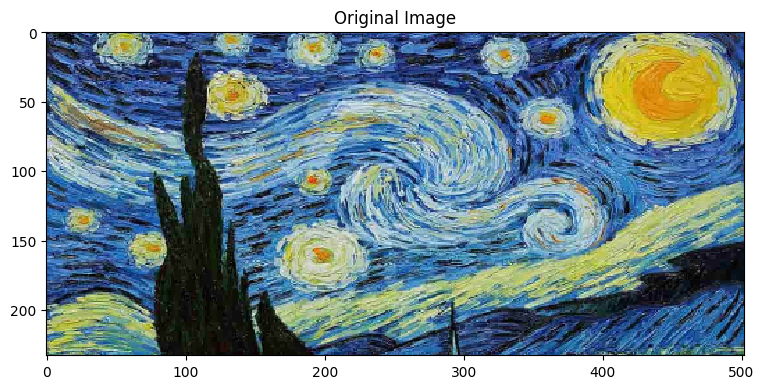

In [50]:
image_file = 'images/Starry.png' # Image path
original_image_matrix = image_to_matrix(image_file) # Save original image
plt.figure(None,figsize=(9,12))
plt.imshow(original_image_matrix)
plt.title("Original Image")
plt.show()

[[7.59434965e-01 1.17910344e+00 1.56969900e+00 ... 7.14556916e-01
  4.17752831e-01 1.27026099e+00]
 [2.71013797e-01 6.60691336e-01 1.21577676e+00 ... 9.48389922e-01
  1.49850878e-01 8.85683858e-01]
 [3.35023925e-01 1.14982972e+00 1.40922686e+00 ... 1.01385066e+00
  2.27256551e-01 1.23152175e+00]
 ...
 [9.50504421e-03 4.09613671e-03 3.91757056e-02 ... 4.61808235e-03
  5.00040253e-03 8.63569352e-03]
 [5.02348172e-04 8.51584434e-05 1.38856087e-03 ... 7.97177027e-05
  1.33793400e-04 1.87515862e-04]
 [8.09414177e-04 2.55045682e-04 2.97470583e-03 ... 1.99373893e-04
  3.67626393e-04 4.80834221e-04]]
[[2.20766001e+00 3.32153963e+00 3.45568725e+00 ... 2.31810011e+00
  9.19904514e-01 3.38864455e+00]
 [2.36099143e-01 1.11505387e+00 2.00770753e+00 ... 2.20260948e+00
  5.28473161e-02 1.38734550e+00]
 [4.43338992e-01 2.24670838e+00 2.71204659e+00 ... 2.64512884e+00
  1.59327075e-01 2.35850451e+00]
 ...
 [2.16029219e-03 1.16724799e-03 9.53324368e-03 ... 6.58244050e-04
  2.10505299e-03 2.19972427e-03]

[[2.16163283e-02 1.16141341e+00 7.46038119e-01 ... 5.58504876e-01
  9.59608158e-02 2.85073736e+00]
 [1.45872489e+01 1.23963195e-04 1.51905355e-04 ... 3.12034782e+00
  7.00726445e+00 2.29612491e-02]
 [2.59451861e+01 2.08193404e-03 1.55817907e-03 ... 4.69358101e+00
  1.13998398e+01 1.91673910e-01]
 ...
 [4.51058707e-04 5.21964525e-05 4.11048870e-03 ... 1.69927793e-03
  1.98297390e-04 6.27291927e-04]
 [2.33445776e-07 1.21146722e-06 6.19707572e-04 ... 3.51423163e-06
  5.77728107e-08 2.22785073e-05]
 [6.18945858e-07 9.74242625e-06 3.28549101e-03 ... 1.41166092e-05
  2.35102182e-07 1.67498448e-04]]
[[3.04999062e-03 1.02214478e+00 6.29300305e-01 ... 3.27441190e-01
  2.11603815e-02 2.69119300e+00]
 [1.73010043e+01 4.61905144e-05 3.54159615e-05 ... 2.81779431e+00
  7.80128002e+00 1.49740977e-02]
 [3.13468977e+01 9.51261135e-04 4.61862944e-04 ... 4.54545862e+00
  1.32129984e+01 1.48903246e-01]
 ...
 [2.78904107e-04 1.80359014e-05 4.54831669e-03 ... 2.48805110e-03
  1.41256083e-04 3.62928767e-04]

[[3.71076317e+00 3.61659652e+00 2.65594624e+00 ... 1.77631446e+00
  2.05852254e+00 3.44808221e+00]
 [7.79582933e+00 1.14658997e+00 3.81246296e-01 ... 2.02824956e-01
  3.27163895e-01 5.49749667e-01]
 [8.69244328e+00 1.76008866e+00 9.38456450e-01 ... 4.61761968e-01
  7.16985052e-01 1.20484057e+00]
 ...
 [1.92502505e-05 8.56259723e-05 3.18193628e-04 ... 1.86499033e-02
  2.11846550e-02 2.88201690e-03]
 [4.60507717e-10 4.07554807e-08 1.38802800e-06 ... 5.08093181e-04
  1.07116361e-03 2.55496051e-05]
 [3.19284774e-09 1.67404419e-07 7.25076001e-06 ... 2.00838444e-03
  3.71805447e-03 1.16657016e-04]]
[[1.34518713e+00 3.78689842e+00 2.47803488e+00 ... 1.85646055e+00
  2.02965023e+00 3.45693542e+00]
 [1.41971106e+01 9.67124239e-01 2.03566795e-01 ... 4.83977588e-02
  1.29183975e-01 2.32218712e-01]
 [1.92107645e+01 1.70372360e+00 6.27837793e-01 ... 1.63994026e-01
  3.86539715e-01 7.21437219e-01]
 ...
 [1.85362676e-06 2.70822490e-05 1.46514820e-04 ... 1.19372813e-02
  1.64504698e-02 1.27954535e-03]

[[9.37198890e-01 7.27686983e-01 5.42603333e-01 ... 4.19169880e-01
  6.80489378e-01 7.90478328e-01]
 [3.71346590e-01 2.96431905e-01 8.22277620e-01 ... 1.48669986e-01
  1.13740121e+00 3.40954952e-01]
 [6.03884267e-01 4.09905557e-01 6.29891866e-01 ... 2.44294061e-01
  1.02338922e+00 4.99054449e-01]
 ...
 [4.40992467e-03 3.00143670e-03 4.92867462e-02 ... 2.89411656e-02
  9.78098406e-03 1.08661116e-02]
 [9.11523166e-05 5.96196348e-05 2.88209889e-03 ... 3.18283128e-03
  2.18560861e-04 4.54766449e-04]
 [2.63020916e-04 1.88903209e-04 3.68561243e-03 ... 8.18853937e-03
  4.30264091e-04 1.14332339e-03]]
[[3.13310807e+00 2.52142488e+00 1.88456266e+00 ... 1.18800111e+00
  2.53303973e+00 2.44233359e+00]
 [4.32979062e-01 4.56453497e-01 1.53829309e+00 ... 8.07994817e-02
  2.36953496e+00 2.83064574e-01]
 [1.08731610e+00 8.69627339e-01 1.71609428e+00 ... 2.41748271e-01
  2.89719347e+00 7.24931776e-01]
 ...
 [2.16358216e-03 2.62588572e-03 6.62510711e-03 ... 7.75030597e-03
  1.34239172e-03 4.71206467e-03]

[[9.28462932e-01 1.38927057e+00 7.18787717e-03 ... 3.03120639e+00
  4.71002660e-01 3.30862411e+00]
 [3.63063594e-04 2.04669929e+00 2.63889824e+01 ... 5.06769178e-03
  2.89479349e-06 2.18844283e-03]
 [3.73022760e-03 3.15013309e+00 5.61551630e+01 ... 5.02521581e-02
  2.45594665e-04 2.61208286e-02]
 ...
 [5.89369381e-03 8.91350293e-04 2.56760156e-06 ... 1.25344230e-05
  5.12631689e-06 2.14388411e-05]
 [8.53841472e-04 2.84171288e-06 1.92032157e-11 ... 4.70425737e-08
  8.76358260e-08 1.09677783e-07]
 [4.76172743e-03 9.30659474e-06 5.07500062e-11 ... 4.21594534e-07
  5.74266973e-06 1.00917370e-06]]
[[7.63350271e-01 9.92944000e-01 1.04479826e-03 ... 2.50900553e+00
  3.41722547e-01 2.76190889e+00]
 [6.83896130e-05 1.71910426e+00 3.08324807e+01 ... 1.52748194e-03
  2.22626214e-07 6.07016260e-04]
 [9.55911364e-04 3.01978944e+00 6.32103884e+01 ... 2.13648594e-02
  4.03299297e-05 9.95346342e-03]
 ...
 [4.37257976e-03 1.22995483e-03 2.35369667e-06 ... 2.17575874e-06
  8.23306851e-07 5.00947568e-06]

[[2.83544628e+00 6.12669025e-01 4.23341870e+00 ... 3.62624423e+00
  2.63048122e+00 1.36832846e+00]
 [6.24120089e+00 4.80001350e-02 4.25790572e-01 ... 8.30889983e-01
  3.97888852e-01 1.73753657e-01]
 [7.19488236e+00 1.30630863e-01 9.71827967e-01 ... 1.92100354e+00
  7.60324085e-01 3.80654040e-01]
 ...
 [9.10061169e-04 2.49309348e-03 3.68124560e-04 ... 6.85119275e-04
  1.29514608e-03 1.18367934e-02]
 [7.13638112e-07 1.02637121e-04 1.26906800e-06 ... 3.08328575e-06
  4.33034365e-06 3.49424546e-04]
 [3.29264518e-06 4.16457058e-04 4.47468563e-06 ... 1.29126640e-05
  1.98932386e-05 1.41332532e-03]]
[[1.17975305e+00 5.49556387e-01 4.33162529e+00 ... 3.59569571e+00
  2.52234659e+00 1.34140300e+00]
 [1.06191667e+01 7.38866705e-03 1.15952188e-01 ... 6.02463996e-01
  1.40517028e-01 3.91166786e-02]
 [1.30456051e+01 3.69637944e-02 4.47556892e-01 ... 1.73025331e+00
  3.53449086e-01 1.31227749e-01]
 ...
 [3.21184361e-04 1.16135655e-03 4.62634527e-05 ... 1.87871595e-04
  9.40314265e-04 1.15943337e-02]

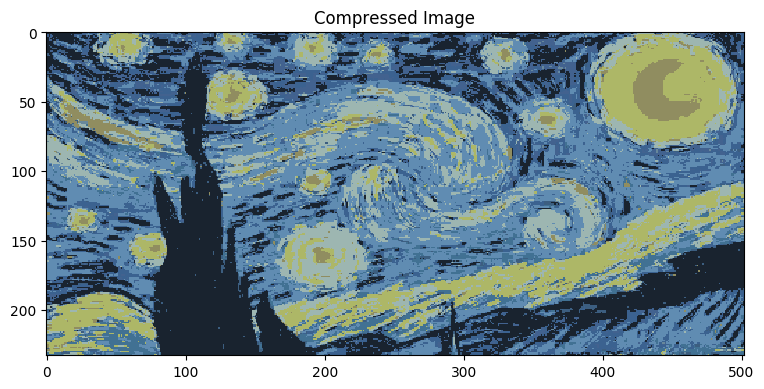

In [51]:
image_file = 'images/Starry.png' # Image path
original_image_matrix = image_to_matrix(image_file) # Save original image
image_matrix = original_image_matrix.reshape(-1,3) # collapse the dimension
K = 10 # K
_, best_seg = best_segment(image_matrix, K, iters = 10)
new_image = best_seg.reshape(*original_image_matrix.shape) # reshape collapsed matrix to original size
plt.figure(None,figsize=(9,12))
plt.imshow(new_image)
plt.title("Compressed Image")
plt.show()

RGBD (**RGB** + **D**epth) data is usually stored as two separated images, one contains RGB (color) information and second one contains only depth, thus is a grayscale image. Let's load a data sample visualize it.

In [52]:
import open3d as o3d

In [53]:
# Function below load the data͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
def load_rgbd_image(image_path, depth_path):
    color_raw = o3d.io.read_image(image_path)
    depth_raw = o3d.io.read_image(depth_path)
    #  details about function http://www.open3d.org/docs/tutorial/Basic/rgbd_odometry.html͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
    # We are using a data sample from the SUN RGB-D (http://rgbd.cs.princeton.edu/) dataset͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
    return color_raw, depth_raw

# We can plot these images separately using the function below͏︆͏󠄃͏󠄌͏󠄍͏󠄂͏️͏︎͏︌͏󠄉
def plot_rgbd(color_image, depth_image):
    plt.figure(None,(15,15))
    plt.subplot(1, 3, 1)
    plt.title('Color image')
    plt.imshow(color_image)
    plt.subplot(1, 3, 2)
    plt.title('SUN depth image')
    plt.imshow(depth_image)
    plt.show()

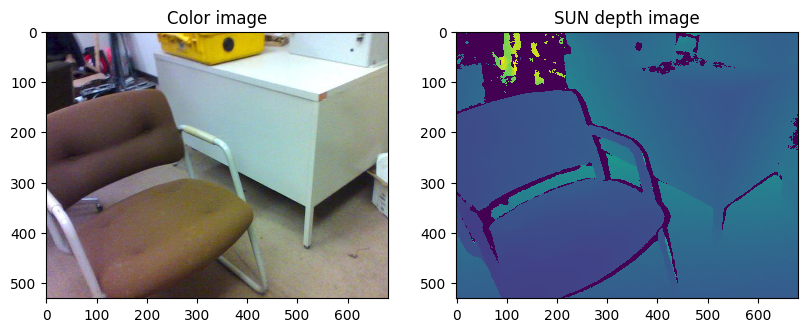

In [54]:
import glob
from PIL import Image
%matplotlib inline
rgbd_dataset = glob.glob('rgbd/image/*.jpg') 
image_number = 3 # [0,4] there are five different images in the folder

image_file = rgbd_dataset[image_number]
depth_file = image_file.replace('image','depth')[:-4] + '.png'
assert os.path.isfile(image_file); 
assert os.path.isfile(depth_file);
color_image, depth_image = load_rgbd_image(image_file, depth_file)
plot_rgbd(color_image, depth_image)

In [55]:
def show_point_cloud(color_raw, depth_raw):
    rgbd_image = o3d.geometry.create_rgbd_image_from_sun_format(color_raw, depth_raw);
    pcd = o3d.geometry.create_point_cloud_from_rgbd_image(rgbd_image, 
                 o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
    o3d.visualization.draw_geometries([pcd])
    return pcd
pcd = show_point_cloud(color_image, depth_image)
pcd_points = np.asarray(pcd.points)

In [56]:
K = 5
initial_params = initialize_parameters(pcd_points, K)
MU, SIGMA, PI, r = train_model(pcd_points, K,
                               convergence_function=default_convergence,
                               initial_values=initial_params)
clusters = cluster(r)

[[4.51846132e-13 1.53053664e-13 2.99314282e-12 1.66136157e-09
  2.20267918e-13]
 [2.25689423e-12 8.46126942e-13 1.29828746e-11 6.35341978e-09
  1.24778973e-12]
 [3.62715737e-12 1.41304383e-12 2.00274213e-11 9.53746684e-09
  2.09225366e-12]
 ...
 [4.24299767e-03 2.32636070e-02 1.28886578e-02 7.96276911e-03
  6.70592643e-03]
 [4.22673855e-03 2.32133473e-02 1.29136066e-02 7.94682910e-03
  6.69531502e-03]
 [4.18273140e-03 2.32223537e-02 1.28183836e-02 7.87439414e-03
  6.65267221e-03]]
[[8.09778764e-23 2.20949312e-36 2.74987846e-29 1.21879427e-05
  1.41008695e-39]
 [1.67900093e-21 4.20776320e-34 1.85489035e-27 2.24095716e-05
  5.62499051e-37]
 [4.13772455e-21 2.03049321e-33 6.54930256e-27 2.69984705e-05
  3.41459945e-36]
 ...
 [3.92040073e-03 3.83165347e-02 1.34683968e-02 6.49440995e-03
  9.95310931e-03]
 [3.89605948e-03 3.79992227e-02 1.34153938e-02 6.49939235e-03
  9.87081888e-03]
 [3.83586506e-03 3.77915445e-02 1.32444193e-02 6.40887448e-03
  9.72681004e-03]]
[[4.70331350e-27 5.75699590e

![alt text](images/image_map.png)


In [57]:
import colorsys
HSV_tuples = [(x*1.0/K, 1.0, 1.0) for x in range(K)]
color_maps = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

![alt text](images/color_image_map.png)

### Visualizing the segmented point cloud data

In [58]:
or_pcd = o3d.geometry.PointCloud() # Create new point cloud handler
or_pcd.points = o3d.utility.Vector3dVector(pcd_points) # set point cloud data
colors = np.zeros_like(pcd_points) # initialize colors to 0
for i, point in enumerate(np.unique(clusters)):
    random_color = color_maps[i]
    cluster_mask = (clusters == point) # get the mask of the cluster i
    colors[cluster_mask,:] = random_color # set random color to all the point of this segment
or_pcd.colors = o3d.utility.Vector3dVector(colors) # set color data
o3d.visualization.draw_geometries([or_pcd]) # visualize point cloud

![alt text](images/pcd_clustered.gif)